In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage, signal, spatial

import os
import pandas as pd

from skimage import morphology, graph, segmentation
import skfmm

import gudhi as gd

In [2]:
def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def clean_zeros_2d(img, pad=2):
    foo = np.nonzero(np.any(img, axis=0))[0]
    vceros = np.array([ max([0,foo[0] - pad]), min([img.shape[1], foo[-1]+pad]) ])
    
    foo = np.nonzero(np.any(img, axis=1))[0]
    hceros = np.array([ max([0,foo[0] - pad]), min([img.shape[0], foo[-1]+pad]) ])

    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
    
    return img, vceros, hceros

def pers2numpy(pers):
    bd = np.zeros((len(pers), 3), dtype=float)
    for i in range(len(bd)):
        bd[i, 0] = pers[i][0]
        bd[i, 1:] = pers[i][1]
    return bd

In [34]:
genotypes = ['CAL','MLB','222','299','517','521']
imtype = ['Diseased', 'Healthy', 'Binary']
runnum = 2
src = '../run{:02d}/'.format(runnum)
gdst = src + 'diagnostic/'
pdst = src + 'processed/'
if not os.path.isdir(gdst):
    os.mkdir(gdst)

if not os.path.isdir(pdst):
    os.mkdir(pdst)

gidx = 4
bfiles = sorted(glob(src + '{}*/*-{}*.jpg'.format(imtype[2], genotypes[gidx])))
print('Total number of files:\t{}'.format(len(bfiles)))
bfiles

Total number of files:	8


['../run02/Binary_Images/1-517-1-M227_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/1-517-2-F244_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/3-517-1-F-1325_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/3-517-2-M-1289_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/4-517-1-M-1-378_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/4-517-2-F-1-384_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/5-517-1-M-1-007_ivc.jpg_Binary_roots.jpg',
 '../run02/Binary_Images/5-517-2-F-1- 075_ivc.jpg_Binary_roots.jpg']

In [35]:
idx = 4
print(bfiles[idx])
bimg = read_binary_img(bfiles[idx])
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_ivc')[0].replace(' ','')
img = ndimage.binary_dilation(bimg.copy(), ndimage.generate_binary_structure(2,1), 3)

foo = glob(gdst + bname + '_-_H0_*.csv')
if len(foo) > 0:
    bar = np.array(os.path.splitext(foo[0])[0].split('_')[-4:], dtype=int)
    vceros = bar[:2]; hceros = bar[2:]
    print(vceros, hceros, sep='\t')
    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
else:
    img, vceros, hceros = clean_zeros_2d(img)
    print(vceros, hceros, sep='\n')

../run02/Binary_Images/4-517-1-M-1-378_ivc.jpg_Binary_roots.jpg
[1393 3855]
[   0 4817]


# Connect missing bits to the main component

In [12]:
def merge_strands(gimg, maxdist=100, iterations=3):
    main = gimg.copy()
    rest = gimg.copy()
    lines = np.zeros_like(main)
                          
    label, nums = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    
    print(np.round(100*hist[hargsort[:10]]/np.sum(hist),1))

    # Define the principal connected component and the rest of separate strands
    
    main[label != bins[hargsort[0]]] = False
    rest[label == bins[hargsort[0]]] = False

    # Only consider the pixels at each end of the strands

    skel = morphology.skeletonize(rest)
    g,nodes = graph.pixel_graph(skel, connectivity=2)
    
    argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
    leafx = nodes[argleaf]%skel.shape[1]
    leafy = nodes[argleaf]//skel.shape[1]
    leafz = label[leafy, leafx]

    # Find the pixels of the main component that are closest to these ends
    
    edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)
    eidx = edt[:, leafy, leafx]
    sdist = np.sqrt((leafy - eidx[0])**2 + (leafx - eidx[1])**2)
    eidx = eidx.T
    # For each strand, consider all the ends and draw the shortest possible connecting line
    
    for i in np.unique(leafz):
        dmask = leafz == i
        cidx = np.argmin(sdist[dmask])
        if sdist[dmask][cidx] < maxdist:
            p0 = np.array([leafx[dmask][cidx], leafy[dmask][cidx]])
            p1 = eidx[dmask][cidx][::-1]
            
            lams = np.linspace(0,1, 2*int(sdist[dmask][cidx]))
            line = (p0.reshape(-1,1) + lams*(p1 - p0).reshape(-1,1)).astype(int)
            lines[line[1], line[0]] = True

    lines = ndimage.binary_dilation(lines, ndimage.generate_binary_structure(2,2), iterations)
    gimg = gimg | lines
    
    foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',bar,'connected components after processing')

    return gimg, bar

In [13]:
gimg = img.copy()
maxdist = 50
nums1, nums2 = 2,3

for i in range(6):
    dist = maxdist * (i+1)
    while (nums1 > 1) and (nums1 != nums2):
        nums2 = nums1
        gimg, nums1 = merge_strands(gimg, dist)
    nums2 += 1

if nums1 > 1:
    label, nums = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    gimg[label != bins[hargsort[0]]] = False

    foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',bar,'connected components after ultimate processing')

[78.8  2.1  1.6  1.4  1.3  1.   0.7  0.7  0.7  0.7]
Found 54 connected components after processing
[84.3  2.1  1.6  1.4  1.   0.7  0.7  0.7  0.7  0.6]
Found 51 connected components after processing
[84.9  2.1  1.6  1.4  1.   0.7  0.7  0.7  0.7  0.6]
Found 51 connected components after processing
[84.9  2.1  1.6  1.4  1.   0.7  0.7  0.7  0.7  0.6]
Found 29 connected components after processing
[93.3  1.6  0.7  0.7  0.6  0.5  0.3  0.3  0.2  0.2]
Found 16 connected components after processing
[95.8  1.5  0.7  0.5  0.3  0.2  0.1  0.1  0.1  0.1]
Found 10 connected components after processing
[96.6  1.5  0.7  0.5  0.2  0.1  0.1  0.1  0.1  0. ]
Found 10 connected components after processing
[96.6  1.5  0.7  0.5  0.2  0.1  0.1  0.1  0.1  0. ]
Found 6 connected components after processing
[98.5  0.7  0.5  0.2  0.1  0.1]
Found 6 connected components after processing
[98.5  0.7  0.5  0.2  0.1  0.1]
Found 5 connected components after processing
[98.6  0.6  0.5  0.2  0.1]
Found 5 connected componen

In [33]:
filename = pdst + bname + '_-_completed_binary_{}_{}_{}_{}.npy'.format(*vceros, *hceros)
print(filename)
np.save(filename, gimg, allow_pickle=True)

../run02/processed/4-299-1-M-1-362_-_completed_binary_1143_4219_0_4756.npy


In [26]:

if len(foo) > 0:
    bar = np.array(os.path.splitext(foo[0])[0].split('_')[-4:], dtype=int)
    vceros = bar[:2]; hceros = bar[2:]
    print(vceros, hceros, sep='\t')
    img = img[hceros[0]:hceros[1], vceros[0]:vceros[1]]
else:
    img, vceros, hceros = clean_zeros_2d(img)
    print(vceros, hceros, sep='\n')

1 5 300


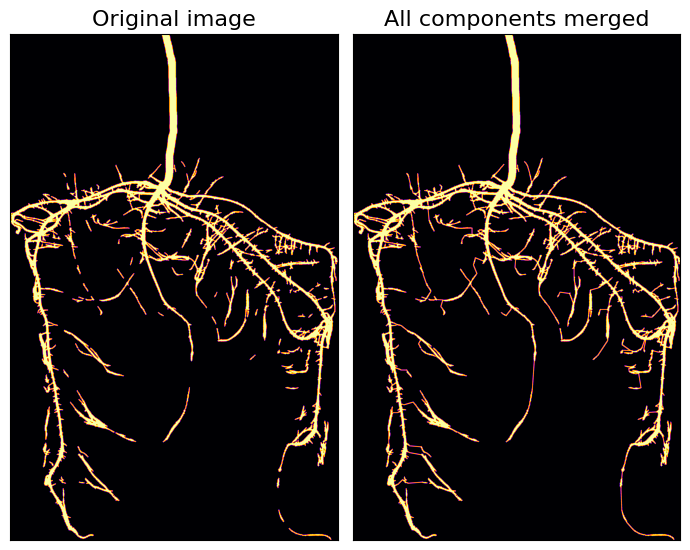

In [24]:
fs = 16; s = 30
fig, ax = plt.subplots(1,2, figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, gimg]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    
i = 0
ax[i].set_title('Original image', fontsize=fs); i+=1
ax[i].set_title('All components merged', fontsize=fs); i+=1

fig.tight_layout();

filename = gdst + bname + '_fixed_strands'
plt.savefig(filename+'.png', format='png', bbox_inches='tight', dpi=200)

In [6]:
label, nums = ndimage.label(img, structure=ndimage.generate_binary_structure(2,1))
print('Found',nums,'connected components')
hist, bins = np.histogram(label, bins=range(1,nums+2))
print(np.round(100*np.sort(hist)[::-1]/np.sum(hist),1))
print(np.sort(hist)[::-1])
hargsort = np.argsort(hist)[::-1]

main = img.copy()
main[label != bins[hargsort[0]]] = False
print('Largest label:\t', bins[hargsort[0]])
edt = ndimage.distance_transform_edt(~main, return_distances=False, return_indices=True)

pad = 5
gimg = img.copy()

rest = img.copy()
rest[label == bins[hargsort[0]]] = False
skel = morphology.skeletonize(rest)
g,nodes = graph.pixel_graph(skel, connectivity=2)

argleaf = np.nonzero(np.sum(g.A > 0, axis=0) == 1)[0]
leafx = nodes[argleaf]%skel.shape[1]
leafy = nodes[argleaf]//skel.shape[1]
leafz = label[leafy, leafx]

eidx = np.zeros((len(leafx), 2), dtype=int)
for i in range(len(eidx)):
    eidx[i] = edt[:, leafy[i], leafx[i]]

sdist = np.zeros(len(leafx))
for i in range(len(sdist)):
    sdist[i] = (leafx[i]-eidx[i,1])**2 + (leafy[i]-eidx[i,0])**2
sdist = np.sqrt(sdist)

for i in range(nums):
    dmask = leafz == i+1
    if np.sum(dmask) > 0:
        cidx = np.argmin(sdist[dmask])
        if sdist[dmask][cidx] < 350:
            p0 = np.array([leafx[dmask][cidx], leafy[dmask][cidx]])
            p1 = eidx[dmask][cidx][::-1]
            
            lams = np.linspace(0,1, 2*int(sdist[dmask][cidx]))
            
            for j in range(len(lams)):
                line = p0 + lams[j]*(p1 - p0)
                line = line.astype(int)
                gimg[ line[1]-pad:line[1]+pad, line[0]-pad:line[0]+pad] = True
        
        else:
            gimg[ label == i+1] = False
            print(i, sdist[dmask], sep='\t')

foo, bar = ndimage.label(gimg, structure=ndimage.generate_binary_structure(2,1))
print('Found',bar,'connected components after processing')

Found 76 connected components
[78.8  2.1  1.6  1.4  1.3  1.   0.7  0.7  0.7  0.7  0.7  0.6  0.6  0.6
  0.6  0.5  0.5  0.5  0.4  0.3  0.3  0.3  0.3  0.3  0.2  0.2  0.2  0.2
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]
[919682  24684  18351  16635  15452  11489   8388   8232   7928   7855
   7762   7216   7143   7135   6538   6175   5513   5498   4203   3796
   3688   3649   3552   3145   2330   1958   1930   1910   1726   1710
   1707   1683   1648   1628   1587   1566   1517   1417   1367   1348
   1251   1226   1188   1155   1144   1064   1046    982    955    904
    842    817    791    778    726    710    697    661    638    638
    594    591    582    567    562    545    542    541    530    529
    527    525    503    503    489    437]
Largest label:	 1
55	[383.18924828 444.8820

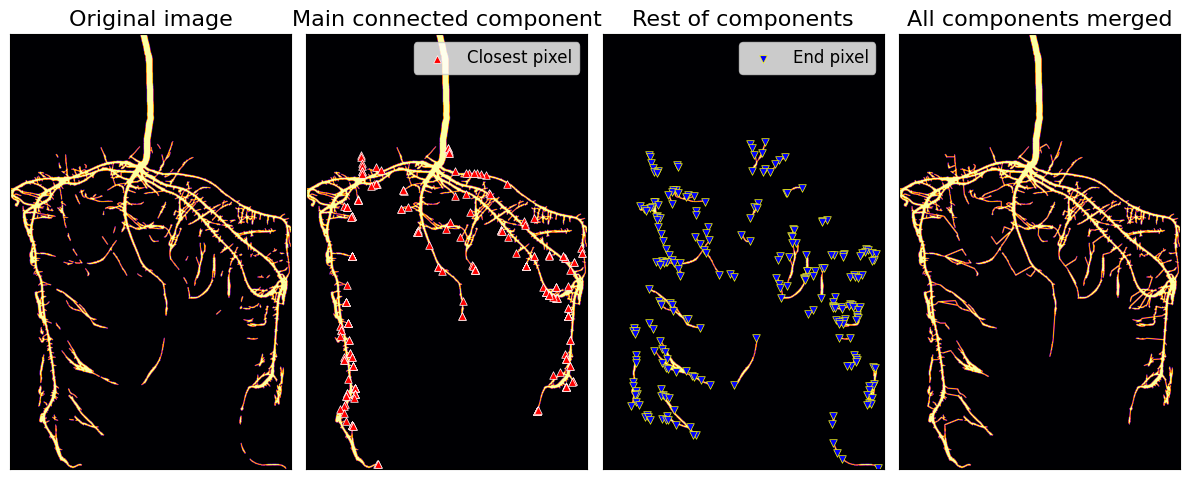

In [32]:
fs = 16; s = 30
fig, ax = plt.subplots(1,4, figsize=(12,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([img, main, rest, gimg]):
    ax[i].imshow(im, cmap='inferno', vmin=0, origin='upper')
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    
ax[1].scatter(eidx[:,1], eidx[:,0], c='red', marker='^', edgecolor='w', linewidth=0.5, s=s, label='Closest pixel')
ax[2].scatter(leafx, leafy, c='blue', marker='v', edgecolor='yellow', linewidth=0.5, s=s, label='End pixel')
for i in [1,2]:
    ax[i].legend(loc='upper right', fontsize=fs-4)

i = 0
ax[i].set_title('Original image', fontsize=fs); i+=1
ax[i].set_title('Main connected component', fontsize=fs); i+=1
ax[i].set_title('Rest of components', fontsize=fs); i+=1
ax[i].set_title('All components merged', fontsize=fs); i+=1

fig.tight_layout();

# Compute the Geodesic Distance Transform

In [ ]:
m = np.copy(gimg)
m[0, gimg[0] ] = False
m = np.ma.masked_array(m, ~gimg)

gdt = skfmm.distance(m).data

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([gimg, gdt, gdt - gimg*np.arange(len(gdt)).reshape(-1,1)]):
    ax[i].imshow(im, cmap='inferno', origin='upper', vmin=0)
fig.tight_layout()

# Compute root tips via 0D persistence with geodesic filter

In [ ]:
filename = gdst + bname + '_-_H0_{}_{}_{}_{}.csv'.format(*vceros, *hceros)
print(filename)
inv = np.max(gdt) - gdt
main = np.ravel(inv, 'F')
    
if not os.path.isfile(filename):
    cc = gd.CubicalComplex(top_dimensional_cells = inv)
    pers = cc.persistence(homology_coeff_field=2, min_persistence=10)
    cof = cc.cofaces_of_persistence_pairs()
    print(len(cof), len(cof[0]), len(cof[0][0]))
    print(len(cof), len(cof[0]), len(cof[0][1]))
    print(len(cof), len(cof[1]), len(cof[1][0]))

    bd = pers2numpy(pers)
    bd = np.atleast_2d(bd[np.all(bd < np.inf, axis=1), :]).squeeze()
    bd0 = bd[bd[:,0] == 0, 1:]
    bd0 = np.vstack(([0,np.max(gdt)], bd0))
    bd0 = bd0[np.argsort(bd0[:,1])[::-1]]
    lt = bd0[:,1] - bd0[:,0]
    
    foo = np.argsort(main[cof[0][0][:,1]])[::-1]
    rest = np.vstack(([cof[1][0][0], gdt.shape[0]*int(ndimage.center_of_mass(gimg[0])[0])], cof[0][0][foo]))
    tips = np.column_stack((rest[:,0]%gdt.shape[0], rest[:,0]//gdt.shape[0]))
    merge = np.column_stack((rest[:,1]%gdt.shape[0], rest[:,1]//gdt.shape[0]))
    print(np.sum(main[rest] != bd0))
    
    birthdeath = pd.DataFrame(bd0, columns=['birth','death'])
    birthdeath['lifetime'] = lt
    birthdeath = pd.concat((birthdeath, pd.DataFrame(rest, columns=['tipF','endF'])), axis=1)
    birthdeath = pd.concat((birthdeath, pd.DataFrame(tips, columns=['tipX','tipY'])), axis=1)
    birthdeath = pd.concat((birthdeath, pd.DataFrame(merge, columns=['endX','endY'])), axis=1)
    birthdeath.to_csv(filename, index=False)

birthdeath = pd.read_csv(filename)
bd0 = birthdeath.loc[:, ['birth','death']].values
lt = birthdeath['lifetime'].values
rest = birthdeath.loc[:, ['tipF','endF']].values
tips = birthdeath.loc[:, ['tipX','tipY']].values
merge = birthdeath.loc[:, ['endX', 'endY']].values

geodesic = np.zeros(len(birthdeath))
for i in range(len(geodesic)):
    geodesic[i] = gdt[tuple(tips[i])]

# Must fit 1 out of 3 criteria to be considered a tip

- Long geodesic distance and part of the convex hull
- Longer lifespan
- Nothing else below a 50px thick strip

In [ ]:
# Convex hull criterion

tconvexhull = spatial.ConvexHull(np.flip(tips, axis=1))
thull = tconvexhull.points[tconvexhull.vertices]
thull = np.vstack((thull, thull[0])).T

chmask = np.zeros(len(tips), dtype=bool)
chmask[tconvexhull.vertices] = True
chmask = chmask & (geodesic > 0.75*gimg.shape[1]) & (lt > 0.1*gimg.shape[1])

if False:
    mconvexhull = spatial.ConvexHull(np.flip(merge[tmask][1:], axis=1))
    mhull = mconvexhull.points[mconvexhull.vertices]
    mhull = np.vstack((mhull, mhull[0])).T

# Lifespan criterion

lmask = lt > 0.25*gdt.shape[0]

# Vertical drop criterion

zpad = 10
zeros = np.zeros(len(tips), dtype=int)

for i in range(len(zeros)):
    foo = gimg[:tips[i,0] - 1 , max([tips[i,1] - zpad, 0]):min([tips[i,1]+zpad, gimg.shape[1]])]
    bar = gimg[tips[i,0] + 1: , max([tips[i,1] - zpad, 0]):min([tips[i,1]+zpad, gimg.shape[1]])]
    zeros[i] = min([100*np.sum(foo)/foo.size, 100*np.sum(bar)/bar.size])

vmask = (zeros < 2) & (lt > 0.25*gimg.shape[1])

tmask = chmask | vmask | lmask

In [ ]:
ss = np.s_[1500:2000, 0:500]
extent = (ss[1].start, ss[1].stop, ss[0].stop, ss[0].start)

fig, ax = plt.subplots(1,4, figsize=(12,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

for i,mask in enumerate([lmask, chmask, vmask, tmask]):
    ax[i].imshow(gdt, cmap='inferno', origin='upper', vmin=0)
    ax[i].scatter(tips[mask,1], tips[mask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
    ax[i].scatter(merge[mask,1], merge[mask,0], marker='D', color='cyan', edgecolor='w', linewidth=1)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])

fig.tight_layout()

# Make a proper geodesic watershed

In [ ]:
label[tuple(tips[tmask][3])]

In [ ]:
watershed = np.zeros(inv.shape, dtype=np.uint8)
colorval = 1
colordict = dict()

#fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); k = 0

ix = np.sum(tmask)-1
print('Iteration:\t', ix, '\n')
thr = main[rest[tmask][ix,1]]
timg = gimg*(inv < thr)

label, nums = ndimage.label( timg, structure=ndimage.generate_binary_structure(2,1))
print('Found',nums,'connected components')
hist, bins = np.histogram(label, bins=range(1,nums+2))
hargsort = np.argsort(hist)[::-1]
mainlabels = np.zeros(ix+1, dtype=int)
for i in range(len(mainlabels)):
    foo = label[tuple(tips[tmask][i])]
    mainlabels[i] = foo-1
mainlabels = mainlabels[mainlabels > -1]
minorlabels = np.setdiff1d(range(nums), mainlabels)
print('Main labels:\t',mainlabels,'\nMinor labels:\t',minorlabels)

if False:
    foo = timg*inv
    ends = np.asarray(ndimage.maximum_position(foo, label, index=range(1,nums+1)))
    sdist = spatial.distance_matrix(ends[mainlabels], ends[minorlabels])
    
    for i in range(len(mainlabels)):
        mask = (watershed == 0) & (label == mainlabels[i] + 1)
        watershed[mask] = colorval
        extras = np.nonzero(mainlabels[np.argmin(sdist, axis=0)] == mainlabels[i])[0]
        for j in minorlabels[extras]:
            mask = (watershed == 0) & (label == j+1)
            watershed[mask] = colorval
        
        colorlist = []
        for j in range(len(tips[tmask])):
            if label[tuple(tips[tmask][j])] == mainlabels[i] + 1:
                colorlist.append(rest[tmask][j,0])
        colordict[colorval] = colorlist
        colorval += 1
    
    #ax[k].imshow(watershed, cmap='Blues', origin='upper', vmin=0, vmax=len(colordict)); k+=1

In [ ]:
watershed = np.zeros(inv.shape, dtype=np.uint8)
colorval = 1
colordict = dict()

#fig, ax = plt.subplots(1,len(rest[tmask]), figsize=(12,5), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); k = 0

for ix in range(len(rest[tmask])-1, -1, -1):
    print('Iteration:\t', ix, '\n')
    thr = main[rest[tmask][ix,1]]
    timg = gimg*(inv < thr)
    
    label, nums = ndimage.label( timg, structure=ndimage.generate_binary_structure(2,1))
    print('Found',nums,'connected components')
    hist, bins = np.histogram(label, bins=range(1,nums+2))
    hargsort = np.argsort(hist)[::-1]
    mainlabels = np.zeros(ix+1, dtype=int)
    for i in range(len(mainlabels)):
        foo = label[tuple(tips[tmask][i])]
        mainlabels[i] = foo-1
    mainlabels = mainlabels[mainlabels > -1]
    minorlabels = np.setdiff1d(range(nums), mainlabels)
    print('Main labels:\t',mainlabels,'\nMinor labels:\t',minorlabels,'\n--\n')
    
    foo = timg*inv
    ends = np.asarray(ndimage.maximum_position(foo, label, index=range(1,nums+1)))
    sdist = spatial.distance_matrix(ends[mainlabels], ends[minorlabels])

    for i in range(len(mainlabels)):
        mask = (watershed == 0) & (label == mainlabels[i] + 1)
        watershed[mask] = colorval
        extras = np.nonzero(mainlabels[np.argmin(sdist, axis=0)] == mainlabels[i])[0]
        for j in minorlabels[extras]:
            mask = (watershed == 0) & (label == j+1)
            watershed[mask] = colorval
        
        colorlist = []
        for j in range(len(tips[tmask])):
            if label[tuple(tips[tmask][j])] == mainlabels[i] + 1:
                colorlist.append(rest[tmask][j,0])
        colordict[colorval] = colorlist
        colorval += 1

    #ax[k].imshow(watershed, cmap='Blues', origin='upper', vmin=0, vmax=len(colordict)); k+=1

In [ ]:
print(len(colordict))
colordict

In [ ]:
cmap = plt.get_cmap('Blues', len(colordict) + 1)

fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

a = ax[0].imshow(watershed, cmap=cmap, origin='upper', vmin=-.5, vmax=len(colordict)+.5)
ax[0].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
ax[0].scatter(merge[tmask,1], merge[tmask,0], marker='*', color='white', edgecolor='magenta', linewidth=1)
cax = plt.colorbar(a, ticks=range(len(colordict) + 1))

fig.tight_layout()

```
Found 8 connected components
[70.7 16.4 12.4  0.3  0.2  0.1  0.   0. ]
[558372 129166  97834   2186   1752    637      1      1]
```

In [ ]:
fig, ax = plt.subplots(1,signif0.size-1, figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i, thr in enumerate(np.sort(signif0.ravel())[1:]):
    ax[i].imshow(gimg*(inv < thr), vmin = 0, vmax = 1, cmap='inferno', origin='upper')
    ax[i].set_title(np.round(thr,1), fontsize=14)
    #ax[i].scatter(tipy[tmask,0], tipx[tmask,0], marker='o', color='r', edgecolor='cyan', linewidth=1)
    #ax[i].scatter(tipy[tmask,1], tipx[tmask,1], marker='D', color='cyan', edgecolor='r', linewidth=1)
    ax[i].scatter(ends[mainlabels,1], ends[mainlabels,0], marker='D', color='cyan', edgecolor='r', linewidth=1, zorder=2)
    ax[i].scatter(ends[minorlabels,1], ends[minorlabels,0], marker='o', color='r', edgecolor='cyan', linewidth=1, zorder=3)

fig.tight_layout();

In [ ]:
wshds = np.zeros((len(tips[tmask]), gimg.shape[0], gimg.shape[1]))

for i in range(len(wshds)):
    m = np.copy(gimg)
    m[tuple(tips[tmask][i])] = False
    m = np.ma.masked_array(m, ~gimg)
    wshds[i] = skfmm.distance(m).data

watershed = np.min(wshds, axis=0)
argwatershed = np.argmin(wshds, axis=0)
argwatershed[gimg] += 1

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate([watershed, argwatershed]):
    ax[i].imshow(im, cmap='inferno', origin='upper', vmin=0)
    #ax[i].scatter(foo[1], foo[0], marker='.', color='r', alpha=0.1)
    #ax[i].set_xlim(extent[0],extent[1]); ax[i].set_ylim(extent[2],extent[3])
    #ax[i].axvline(ix[1] + .5, c='r'); ax[i].axhline(ix[0] + .5, c='r')

#fig.delaxes(ax[-1])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,len(wshds), figsize=(12,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    
    ax[i].imshow(wshds[i], vmin = 0, cmap='inferno', origin='upper')
    ax[i].scatter(tips[tmask,1], tips[tmask,0], marker='o', color='r', edgecolor='lime', linewidth=1)
    ax[i].scatter(merge[tmask,1], merge[tmask,0], marker='D', color='cyan', edgecolor='white', linewidth=1)

fig.tight_layout();